Iter 1/100 - Loss: 0.914
Iter 2/100 - Loss: 0.882
Iter 3/100 - Loss: 0.849
Iter 4/100 - Loss: 0.817
Iter 5/100 - Loss: 0.784
Iter 6/100 - Loss: 0.750
Iter 7/100 - Loss: 0.717
Iter 8/100 - Loss: 0.683
Iter 9/100 - Loss: 0.649
Iter 10/100 - Loss: 0.616
Iter 11/100 - Loss: 0.581
Iter 12/100 - Loss: 0.547
Iter 13/100 - Loss: 0.512
Iter 14/100 - Loss: 0.478
Iter 15/100 - Loss: 0.443
Iter 16/100 - Loss: 0.408
Iter 17/100 - Loss: 0.373
Iter 18/100 - Loss: 0.338
Iter 19/100 - Loss: 0.304
Iter 20/100 - Loss: 0.270
Iter 21/100 - Loss: 0.236
Iter 22/100 - Loss: 0.204
Iter 23/100 - Loss: 0.172
Iter 24/100 - Loss: 0.140
Iter 25/100 - Loss: 0.110
Iter 26/100 - Loss: 0.081
Iter 27/100 - Loss: 0.053
Iter 28/100 - Loss: 0.027
Iter 29/100 - Loss: 0.002
Iter 30/100 - Loss: -0.022
Iter 31/100 - Loss: -0.044
Iter 32/100 - Loss: -0.064
Iter 33/100 - Loss: -0.082
Iter 34/100 - Loss: -0.098
Iter 35/100 - Loss: -0.112
Iter 36/100 - Loss: -0.124
Iter 37/100 - Loss: -0.133
Iter 38/100 - Loss: -0.141
Iter 39/100 

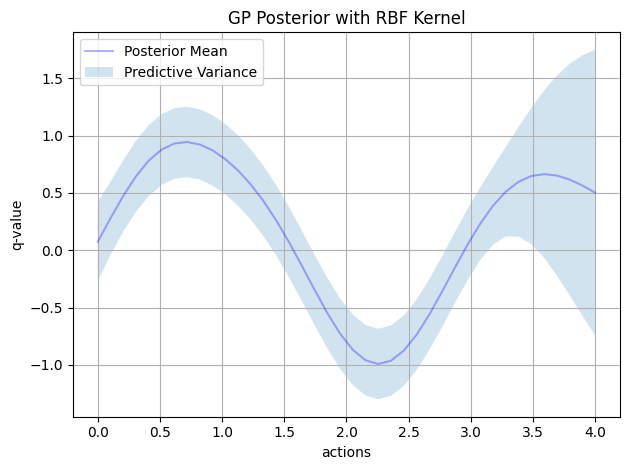

In [7]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Generate evenly spaced points over [0, 3.2]
train_x = torch.linspace(0, 3.2, 40)
test_x = torch.linspace(0, 4, 40)

# Generate sinusoidal data without noise, with peaks at 1 and 4
train_y = torch.sin(train_x * (2 * 3.14159 / 3)) + torch.randn(train_x.size()) * 0.135

# Set up the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
training_iterations = 100
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    post_mean = observed_pred.mean
    post_lower, post_upper = observed_pred.confidence_region()

    # Draw samples from the posterior
    samples = observed_pred.sample(torch.Size([1]))

# Plot the posterior mean and variance
plt.plot(test_x.numpy(), post_mean.numpy(), 'b', label='Posterior Mean', alpha=0.3)
plt.fill_between(test_x.numpy(), post_lower.numpy(), post_upper.numpy(), alpha=0.2, label='Predictive Variance')

# Plot the sampled functions from the posterior
# for i, sample in enumerate(samples):
#    plt.plot(test_x.numpy(), sample.numpy(), '--', label=f'Sample Function {i+1}')

plt.title('GP Posterior with RBF Kernel')
plt.xlabel('actions')
plt.ylabel('q-value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("posterior_samples_rbf_with_samples.png", dpi=300)
plt.show()
